#### In this project we well construct a regression model  predict people who are particularly generous—those who will tip 20% or more? Consider the following questions:
###### Question 1: What features do you need to make this prediction?
Ideally, we'd have behavioral history for each customer, so we could know how much they tipped on previous taxi rides. We'd also want times, dates, and locations of both pickups and dropoffs, estimated fares, and payment method.
###### Question 2: What would be the target variable?
The target variable would be a binary variable (1 or 0) that indicates whether or not the customer is expected to tip ≥ 20%.

##### This is a supervised learning, classification task. We could use accuracy, precision, recall, F-score, area under the ROC curve, or a number of other metrics. However, we don't have enough information at this time to know which are most appropriate. We need to know the class balance of the target variable.

## Task 1: imports and data loading  

In [4]:
import xgboost
print(xgboost.__version__)


2.1.4


In [5]:
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance 
from xgboost import plot_importance

In [6]:
# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

In [7]:
## load the data frame
df0= pd.read_csv(r"C:\Users\adnan\Downloads\genours customer project\2017_Yellow_Taxi_Trip_Data.csv")
# Import predicted fares and mean distance and duration 
ncy_pred_means =pd.read_csv(r"C:\Users\adnan\Downloads\genours customer project\nyc_preds_means.csv")

In [8]:
# inspect the first rows of the df0
df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


In [9]:
# Inspect the first few rows of `nyc_preds_means`
ncy_pred_means.head()

,mean_duration,mean_distance,predicted_fare
0,22.847222,3.521667,16.434245
1,24.470370,3.108889,16.052218
2,7.250000,0.881429,7.053706
3,30.250000,3.700000,18.731650
4,14.616667,4.435000,15.845642


In [10]:
# merge the two table 
df0 = df0.merge(ncy_pred_means,
               left_index=True,
               right_index=True)

df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,14.616667,4.435000,15.845642


# Analyze

## Task 2: Feature engineering 

In [13]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

we know from  EDA that customers who pay cash generally have a tip amount of $0. To meet the modeling objective, we'll need to sample the data to select only the customers who pay with credit card.

In [15]:
df1 =df0[df0['payment_type']==1]

We need to create new column for tips percent and that by dividing the tip amount over the total amount subtracted from tip amount .
###### notice:
Round the result to three places beyond the decimal. This is an important step. It affects how many customers are labeled as generous tippers. In fact, without performing this step, approximately 1,800 people who do tip ≥ 20% would be labeled as not generous.

In [17]:
## creat the % tip col
df1['tip_percent'] = round(df1['tip_amount']/(df1['total_amount']-df1['tip_amount']),3)
df1=df1.copy()


C:\Users\adnan\AppData\Local\Temp\ipykernel_1968\96391597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['tip_percent'] = round(df1['tip_amount']/(df1['total_amount']-df1['tip_amount']),3)


In [18]:
## now we need to creat a new column for those generous customers 
df1['generous']=df1['tip_percent']
df1['generous']=(df1['generous']>=0.2)
df1['generous']=df1['generous'].astype(int)

In [19]:
df1.sample(5)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous
20184,26784170,2,04/01/2017 1:22:25 PM,04/01/2017 1:40:48 PM,2,1.06,1,N,79,144,1,12.0,0.0,0.5,1.50,0.0,0.3,14.30,9.111404,1.004737,7.491142,0.117,0
7889,94066656,2,11/06/2017 8:08:49 PM,11/06/2017 8:16:18 PM,1,1.08,1,N,140,162,1,7.0,0.5,0.5,1.24,0.0,0.3,9.54,11.234127,1.496667,9.039963,0.149,0
10251,32317937,2,04/20/2017 9:18:21 AM,04/20/2017 9:34:25 AM,1,1.93,1,N,233,113,1,11.5,0.0,0.5,2.46,0.0,0.3,14.76,11.938889,2.010000,10.502023,0.200,1
8121,89015141,1,10/22/2017 1:03:49 AM,10/22/2017 1:12:32 AM,2,1.20,1,N,125,79,1,7.5,0.5,0.5,1.75,0.0,0.3,10.55,12.833333,1.564286,9.753551,0.199,0
5739,76538480,2,09/12/2017 6:24:35 AM,09/12/2017 6:29:00 AM,1,1.92,1,N,230,234,1,7.0,0.0,0.5,1.56,0.0,0.3,9.36,11.968000,1.735600,9.962523,0.200,1


##### creat day column :


Convert the `tpep_pickup_datetime` and `tpep_dropoff_datetime` columns to datetime.

In [22]:
df1['tpep_pickup_datetime']=pd.to_datetime(df1['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df1['tpep_dropoff_datetime']=pd.to_datetime(df1['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

Create a day column that contains only the day of the week when each passenger was picked up. Then, convert the values to lowercase.

In [24]:
df1['day']=df1['tpep_pickup_datetime'].dt.day_name().str.lower()

###  Create time of day columns

Next, engineer four new columns that represent time of day bins. Each column should contain binary values (0=no, 1=yes) that indicate whether a trip began (picked up) during the following times:

`am_rush` = [06:00&ndash;10:00)  
`daytime` = [10:00&ndash;16:00)  
`pm_rush` = [16:00&ndash;20:00)  
`nighttime` = [20:00&ndash;06:00)  

To do this, first create the four columns. For now, each new column should be identical and contain the same information: the hour (only) from the `tpep_pickup_datetime` column.

In [27]:
# creat 'am rush hour'
df1['am_rush'] =df1['tpep_pickup_datetime'].dt.hour
# creat day time col 
df1['daytime'] =df1['tpep_pickup_datetime'].dt.hour
# creat 'pm rush hour'
df1['pm_rush'] =df1['tpep_pickup_datetime'].dt.hour
# creat nighttime col
df1['night_time'] =df1['tpep_pickup_datetime'].dt.hour


You'll need to write four functions to convert each new column to binary (0/1). Begin with `am_rush`. Complete the function so if the hour is between [06:00–10:00), it returns 1, otherwise, it returns 0.

In [29]:
df1


,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous,day,am_rush,daytime,pm_rush,night_time
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.00,0.3,16.56,22.847222,3.521667,16.434245,0.200,1,saturday,8,8,8,8
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.00,0.3,20.80,24.470370,3.108889,16.052218,0.238,1,tuesday,14,14,14,14
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.00,0.3,8.75,7.250000,0.881429,7.053706,0.199,0,friday,7,7,7,7
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.00,0.3,27.69,30.250000,3.700000,18.731650,0.300,1,sunday,13,13,13,13
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.00,0.3,12.36,11.855376,2.052258,10.441351,0.200,1,saturday,20,20,20,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22692,60425673,1,2017-07-16 03:22:51,2017-07-16 03:40:52,1,5.70,1,N,249,17,1,19.0,0.5,0.5,4.05,0.00,0.3,24.35,18.016667,5.700000,19.426247,0.200,1,sunday,3,3,3,3
22693,67858616,2,2017-08-10 22:20:04,2017-08-10 22:29:31,1,0.89,1,N,229,170,1,7.5,0.5,0.5,1.76,0.00,0.3,10.56,8.095370,1.062778,7.300146,0.200,1,thursday,22,22,22,22
22695,66632549,2,2017-08-06 16:43:59,2017-08-06 17:24:47,1,16.71,2,N,132,164,1,52.0,0.0,0.5,14.64,5.76,0.3,73.20,59.560417,18.757500,52.000000,0.250,1,sunday,16,16,16,16
22697,60217333,2,2017-07-15 12:56:30,2017-07-15 13:08:26,1,2.36,1,N,68,144,1,10.5,0.0,0.5,1.70,0.00,0.3,13.00,16.650000,2.077500,11.707049,0.150,0,saturday,12,12,12,12


In [30]:
# Define 'am_rush()' conversion function [06:00–10:00)
def am_rush(hour):
    if 6 <= hour['am_rush'] < 10:
        val = 1
    else:
        val = 0
    return val

In [31]:
# Apply 'am_rush' function to the 'am_rush' series
df1['am_rush'] = df1.apply(am_rush, axis=1)
df1['am_rush'].head()

0    1
1    0
2    1
3    0
5    0
Name: am_rush, dtype: int64

In [32]:
# Define 'daytime()' conversion function [10:00–16:00)
def daytime(hour):
    if 10 <= hour['daytime'] < 16:
        val = 1
    else:
        val = 0
    return val

In [33]:
# Apply 'daytime' function to the 'daytime' series
df1['daytime'] = df1.apply(daytime, axis=1)
df1['daytime']

0        0
1        1
2        0
3        1
5        0
        ..
22692    0
22693    0
22695    0
22697    1
22698    1
Name: daytime, Length: 15265, dtype: int64

In [34]:
def pm_rush(hour):
    if 16 <= hour['pm_rush'] < 20:
        val = 1
    else:
        val = 0
    return val

In [35]:
# Apply 'pm_rush' function to the 'pm_rush' series
df1['pm_rush'] = df1.apply(pm_rush, axis=1)

In [36]:
# Define 'nighttime()' conversion function [20:00–06:00)
def night_time(hour):
    if 20 <= hour['night_time'] < 24:
        val = 1
    elif 0 <= hour['night_time'] < 6:
        val = 1
    else:
        val = 0
    return val

In [37]:
# Apply 'nighttime' function to the 'nighttime' series
df1['night_time'] = df1.apply(night_time, axis=1)

#### Create month column

In [39]:
# Create 'month' col
df1['month'] = df1['tpep_pickup_datetime'].dt.strftime('%b').str.lower()

In [40]:
df1.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous,day,am_rush,daytime,pm_rush,night_time,month
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.200,1,saturday,1,0,0,0,mar
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.238,1,tuesday,0,1,0,0,apr
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.199,0,friday,1,0,0,0,dec
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650,0.300,1,sunday,0,1,0,0,may
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351,0.200,1,saturday,0,0,0,1,mar


#### Drop columns

Drop redundant and irrelevant columns as well as those that would not be available when the model is deployed. This includes information like payment type, trip distance, tip amount, tip percentage, total amount, toll amount, etc. The target variable (`generous`) must remain in the data because it will get isolated as the `y` data for modeling.

In [42]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             15265 non-null  int64         
 1   VendorID               15265 non-null  int64         
 2   tpep_pickup_datetime   15265 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  15265 non-null  datetime64[ns]
 4   passenger_count        15265 non-null  int64         
 5   trip_distance          15265 non-null  float64       
 6   RatecodeID             15265 non-null  int64         
 7   store_and_fwd_flag     15265 non-null  object        
 8   PULocationID           15265 non-null  int64         
 9   DOLocationID           15265 non-null  int64         
 10  payment_type           15265 non-null  int64         
 11  fare_amount            15265 non-null  float64       
 12  extra                  15265 non-null  float64       
 13  mta_ta

In [43]:
# Drop columns
drop_cols = ['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
             'payment_type', 'trip_distance', 'store_and_fwd_flag', 'payment_type',
             'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'total_amount', 'tip_percent']

df1 = df1.drop(drop_cols, axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  int64  
 3   PULocationID     15265 non-null  int64  
 4   DOLocationID     15265 non-null  int64  
 5   mean_duration    15265 non-null  float64
 6   mean_distance    15265 non-null  float64
 7   predicted_fare   15265 non-null  float64
 8   generous         15265 non-null  int32  
 9   day              15265 non-null  object 
 10  am_rush          15265 non-null  int64  
 11  daytime          15265 non-null  int64  
 12  pm_rush          15265 non-null  int64  
 13  night_time       15265 non-null  int64  
 14  month            15265 non-null  object 
dtypes: float64(3), int32(1), int64(9), object(2)
memory usage: 1.8+ MB


#### Variable encoding

Many of the columns are categorical and will need to be dummied (converted to binary). Some of these columns are numeric, but they actually encode categorical information, such as `RatecodeID` and the pickup and dropoff locations. To make these columns recognizable to the `get_dummies()` function as categorical variables, you'll first need to convert them to `type(str)`. 

1. Define a variable called `cols_to_str`, which is a list of the numeric columns that contain categorical information and must be converted to string: `RatecodeID`, `PULocationID`, `DOLocationID`.
2. Write a for loop that converts each column in `cols_to_str` to string.

In [46]:
# 1. Define list of cols to convert to string
cols_to_str = ['RatecodeID', 'PULocationID', 'DOLocationID', 'VendorID']

# 2. Convert each column to string
for col in cols_to_str:
    df1[col] = df1[col].astype('str')

In [47]:
# Convert categoricals to binary
df2 = pd.get_dummies(df1, drop_first=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Columns: 347 entries, passenger_count to month_sep
dtypes: bool(338), float64(3), int32(1), int64(5)
memory usage: 6.0 MB


In [48]:
# Get class balance of 'generous' col
df2['generous'].value_counts(normalize=True)

generous
1    0.526368
0    0.473632
Name: proportion, dtype: float64

A little over half of the customers in this dataset were "generous" (tipped ≥ 20%). The dataset is very nearly balanced.

To determine a metric, consider the cost of both kinds of model error:

False positives (the model predicts a tip ≥ 20%, but the customer does not give one)
False negatives (the model predicts a tip < 20%, but the customer gives more)
False positives are worse for cab drivers, because they would pick up a customer expecting a good tip and then not receive one, frustrating the driver.

False negatives are worse for customers, because a cab driver would likely pick up a different customer who was predicted to tip more—even when the original customer would have tipped generously.

The stakes are relatively even. We want to help taxi drivers make more money, but we don't want this to anger customers. our metric should weigh both precision and recall equally. Which metric is this?

Exemplar response: F1 score is the metric that places equal weight on true postives and false positives, and so therefore on precision and recall.

### Construc the model

In [51]:
# Isolate target variable (y)
y = df2['generous']

# Isolate the features (X)
X = df2.drop('generous', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### Random Forest :
Begin with using `GridSearchCV` to tune a random forest model.

1. Instantiate the random forest classifier `rf` and set the random state.

2. Create a dictionary `cv_params` of any of the following hyperparameters and their corresponding values to tune. The more you tune, the better your model will fit the data, but the longer it will take. 
 - `max_depth`  
 - `max_features`  
 - `max_samples` 
 - `min_samples_leaf`  
 - `min_samples_split`
 - `n_estimators`  

3. Define a set `scoring` of scoring metrics for GridSearch to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `rf1`. Pass to it as arguments:
 - estimator=`rf`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of you cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit=_`)

In [53]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune 
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [0.7],
             'min_samples_leaf': [1],
             'min_samples_split': [2],
             'n_estimators': [300]
             }

# 3. Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='f1')

In [54]:
%%time
rf1.fit(X_train, y_train)

CPU times: total: 12min 48s
Wall time: 13min 18s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [0.7], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [55]:
import pickle 
print(rf1.best_score_)

with open('model.pkl', 'wb') as file:
   pickle.dump(rf1, file)
   file.seek(0)


0.7136009788848704


In [56]:

with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)


Examine the best average score across all the validation folds. 

In [58]:
# Examine best score
rf1.best_score_

0.7136009788848704

Examine the best combination of hyperparameters.

In [60]:
rf1.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [61]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

In [62]:
# Call 'make_results()' on the GridSearch object
results = make_results('RF CV', rf1, 'f1')
results

,model,precision,recall,F1,accuracy
0,RF CV,0.674919,0.757312,0.713601,0.680233


In [63]:
# Get scores on test data
rf_preds = rf1.best_estimator_.predict(X_test)

In [64]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

In [65]:
# Get scores on test data
rf_test_scores = get_test_scores('RF test', rf_preds, y_test)
results = pd.concat([results, rf_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.674919,0.757312,0.713601,0.680233
0,RF test,0.675297,0.779091,0.723490,0.686538


##### We can see that all scores increased by at most ~0.02.

##### We will try to improve your scores using an XGBoost model.

## XGBoost

1. We will instantiate the XGBoost classifier `xgb` and set `objective='binary:logistic'`. Also set the random state.

2. We will create a dictionary `cv_params` of the following hyperparameters and their corresponding values to tune:
 - `max_depth`
 - `min_child_weight`
 - `learning_rate`
 - `n_estimators`

3. Define a set `scoring` of scoring metrics for grid search to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `xgb1`. Pass to it as arguments:
 - estimator=`xgb`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit='f1'`)

In [120]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# 2. Create a dictionary of hyperparameters to tune
# Note that this example only contains 1 value for each parameter for simplicity,
# but you should assign a dictionary with ranges of values
cv_params = {'learning_rate': [0.1],
             'max_depth': [8],
             'min_child_weight': [2],
             'n_estimators': [500]
             }

# 3. Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
xgb1 = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='f1')

In [122]:
%%time
xgb1.fit(X_train, y_train)

CPU times: total: 2min 37s
Wall time: 21.4 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [8],
                         'min_child_weight': [2], 'n_estimators': [500]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

Get the best score from this model.

In [127]:
# Examine best score
xgb1.best_score_

0.6955124635485909

In [129]:
# Examine best parameters
xgb1.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 500}

#### XGB CV results

In [133]:
# Call 'make_results()' on the GridSearch object
xgb1_cv_results = make_results('XGB CV', xgb1, 'f1')
results = pd.concat([results, xgb1_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.674919,0.757312,0.713601,0.680233
0,RF test,0.675297,0.779091,0.723490,0.686538
0,XGB CV,0.669726,0.723553,0.695512,0.666557


In [135]:
# Get scores on test data
xgb_preds = xgb1.best_estimator_.predict(X_test)

###### XGB test results

1. Use the `get_test_scores()` function to generate the scores on the test data. Assign the results to `xgb_test_scores`.
2. Call `xgb_test_scores` to output the results.

In [140]:
# Get scores on test data
xgb_test_scores = get_test_scores('XGB test', xgb_preds, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.674919,0.757312,0.713601,0.680233
0,RF test,0.675297,0.779091,0.723490,0.686538
0,XGB CV,0.669726,0.723553,0.695512,0.666557
0,XGB test,0.677219,0.745488,0.709716,0.679004


The F1 score is ~0.014 lower than the random forest model. Both models are acceptable, but the random forest model is the champion.

Plot a confusion matrix of the champion model's predictions on the test data.

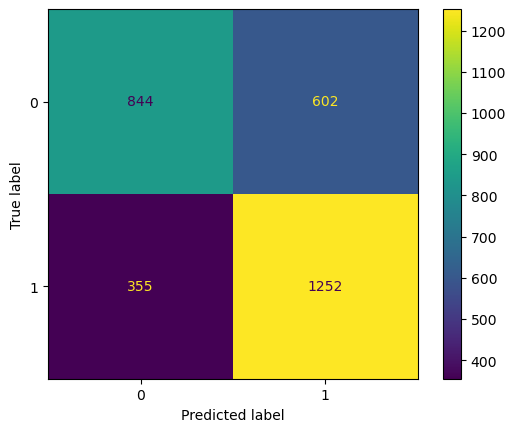

In [142]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, rf_preds, labels=rf1.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf1.classes_, 
                             )
disp.plot(values_format='');

The model is almost twice as likely to predict a false positive than it is to predict a false negative. Therefore, type I errors are more common. This is less desirable, because it's better for a driver to be pleasantly surprised by a generous tip when they weren't expecting one than to be disappointed by a low tip when they were expecting a generous one. However, the overall performance of this model is satisfactory. 

##### Feature importance

Use the `feature_importances_` attribute of the best estimator object to inspect the features of your final model. You can then sort them and plot the most important ones.

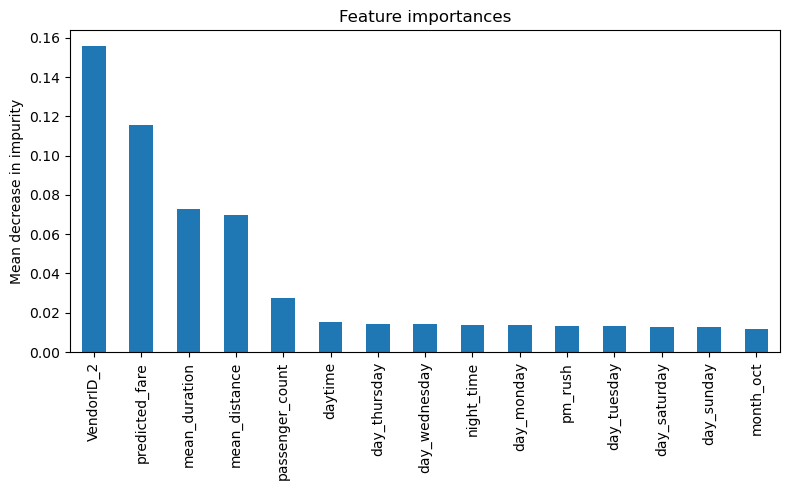

In [147]:
importances = rf1.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)
rf_importances = rf_importances.sort_values(ascending=False)[:15]

fig, ax = plt.subplots(figsize=(8,5))
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout();

It would probably be very helpful to have past tipping behavior for each customer. It would also be valuable to have accurate tip values for customers who pay with cash.
It would be helpful to have a lot more data. With enough data, we could create a unique feature for each pickup/dropoff combination.
